![alt text](source\wids-logo.png) <br>
### Women in Data Science Brown Bag Series: Model Selection, Evaluation, and Parameter Tuning
Sian Lewis (lewis_sian@bah.com)<br>
Marissa Wiener (wiener_marissa@bah.com)<br>
<br>
February 7, 2019

In this brown bag, we explore model selection, hyperparameter tuning, and model evaluation for classic regression and classification models. Learn to choose the best model/algorithm for prediction through different techniques.

### **Part 1:** Model Selection <br>
When choosing a model, consider the objective and use of the model. Some main considerations are listed below: <br><br>
**Data**<br>
How many features and instances are in your dataset? <br>
Is your data sparse? <br>
Are there a lot of null values? Are nulls biased? <br>
Are the attributes in your data correlated?<br>
Are you predicting a continuous or categorical variable?<br><br>
**Interpretability** <br>
Is your purpose accuracy only? Does interpretability not matter at all? <br>
Are there regulations or other business/legal considerations which require an explanation of the model <br>
Could the interpretability of your model be used for other business applications?<br><br>
**Speed**<br>
Is speed of fit important? <br>
Are there any limitations to computing power? <br>

![alt text](source\machinelearning_cheatsheet.png)<br>
**MW NOTE:** Even though this is a SAS graphic, I like this. Maybe recreate something similar but incorporate something about dimensions of data? Lmk what you think.

Let's consider an of model selection for Classification Models:
- *Logistic Regression:* no correlated features, not great to use with a ton of features, highly interpretable output
- *Tree Based Methods:* many features which could be correlated, seeking accuracy but willing to sacrifice a bit of interpretation
    - *Random Forest:* uses bagging to train data (average of model output trained on randomly selected data with replacement), harder to overfit and easier to tune, good with very large data
    - *Gradient Boosted Trees:* train base model, then fit subsequent additive models to residuals, good for imbalanced classes, seeking accuracy, be careful about overfitting; flexible to all differentiable loss functions
- *Neural Nets:* many features, seeking accuracy and no need for interpretation

### **Part 2:** Model Evaluation

In [22]:
import zipfile as z
import pandas as pd
import seaborn as sns
import re
import math
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_curve, auc, accuracy_score
import matplotlib.pyplot as plt
%matplotlib inline

In [20]:
# if you don't have the following packages installed, you can do so here
!pip install shap
!pip install -U imbalanced-learn
!pip install xgboost
import xgboost as xgb

**Get to know the Data**
- Food inspection data from Illinois, indicates pass/fail criteria
- Available on Kaggle: https://www.kaggle.com/chicago/chi-restaurant-inspections

In [23]:
archive = z.ZipFile('data.zip','r')
food_inspections = archive.open('data/food-inspections.csv')
df = pd.read_csv(food_inspections)
df.head()

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude,Location
0,2240307,2 POTZ & A PAN EATERY,2 POTZ & A PAN EATERY,2626283.0,Restaurant,Risk 1 (High),6052 S EBERHART AVE,CHICAGO,IL,60637.0,2018-11-16T00:00:00,License,Pass w/ Conditions,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.784183,-87.613385,"{'longitude': '-87.61338492635632', 'needs_rec..."
1,2240303,"CREMERIA SANTA MARIA, INC",CREMERIA SANTA MARIA,1868311.0,Grocery Store,Risk 1 (High),3424 W 26TH ST,CHICAGO,IL,60623.0,2018-11-16T00:00:00,Canvass Re-Inspection,Pass w/ Conditions,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.844544,-87.711073,"{'longitude': '-87.71107279676545', 'needs_rec..."
2,2240297,ORALE,ORALE,2631871.0,Restaurant,Risk 1 (High),1623 W 43rd ST,CHICAGO,IL,60609.0,2018-11-16T00:00:00,License,Pass w/ Conditions,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.815747,-87.666218,"{'longitude': '-87.66621797293804', 'needs_rec..."
3,2240300,AMAZING GRACE DAYCARE CENTER,AMAZING GRACE DAYCARE CENTER,2215901.0,Daycare Above and Under 2 Years,Risk 1 (High),11123-11125 S HALSTED ST,CHICAGO,IL,60628.0,2018-11-16T00:00:00,Canvass,Pass w/ Conditions,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.691646,-87.642214,"{'longitude': '-87.6422140544927', 'needs_reco..."
4,2240286,JOYS,JOYS,1677471.0,Restaurant,Risk 1 (High),3257-3259 N BROADWAY,CHICAGO,IL,60657.0,2018-11-16T00:00:00,Suspected Food Poisoning,Pass w/ Conditions,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.941713,-87.644306,"{'longitude': '-87.64430633617879', 'needs_rec..."


In [24]:
# format column names to remove whitespace and special characters
df.columns = df.columns.str.lower().str.replace(' ','_').str.replace('#','nb')
df.columns 

Index(['inspection_id', 'dba_name', 'aka_name', 'license_nb', 'facility_type',
       'risk', 'address', 'city', 'state', 'zip', 'inspection_date',
       'inspection_type', 'results', 'violations', 'latitude', 'longitude',
       'location'],
      dtype='object')

In [25]:
print(df.shape)
print(df.dtypes[df.dtypes=='object'])
print(df.dtypes[df.dtypes!='object'])

(178089, 17)
dba_name           object
aka_name           object
facility_type      object
risk               object
address            object
city               object
state              object
inspection_date    object
inspection_type    object
results            object
violations         object
location           object
dtype: object
inspection_id      int64
license_nb       float64
zip              float64
latitude         float64
longitude        float64
dtype: object


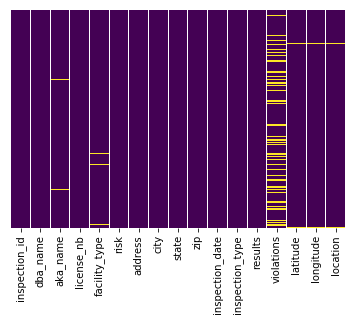

In [26]:
sns.heatmap(df.isnull(), yticklabels = False, cbar = False, cmap = 'viridis')

In [27]:
print(df.results.describe())
df.results.value_counts()

count     178089
unique         7
top         Pass
freq      101807
Name: results, dtype: object


Pass                    101807
Fail                     34505
Pass w/ Conditions       19317
Out of Business          15606
No Entry                  5382
Not Ready                 1408
Business Not Located        64
Name: results, dtype: int64

In [28]:
condition_list = [df['results']=='Pass', df['results'] == 'Pass w/ Conditions']
choice_list = [1,1]
df['pass'] = np.select(condition_list, choice_list, default = 0)
df['fail'] = np.where(df['results']=='Fail', 1, 0)
df.describe()

,inspection_id,license_nb,zip,latitude,longitude,pass,fail
count,1.780890e+05,1.780730e+05,178013.000000,177425.000000,177425.000000,178089.000000,178089.000000
mean,1.361486e+06,1.563803e+06,60628.998466,41.880761,-87.676449,0.680132,0.193751
std,6.042818e+05,8.890138e+05,22.675410,0.080798,0.058927,0.466427,0.395238
min,4.424700e+04,0.000000e+00,60007.000000,41.644670,-87.914428,0.000000,0.000000
25%,1.106299e+06,1.169489e+06,60614.000000,41.832016,-87.707453,0.000000,0.000000
50%,1.441571e+06,1.954184e+06,60625.000000,41.891671,-87.666290,1.000000,0.000000
75%,1.950624e+06,2.215518e+06,60643.000000,41.939692,-87.634789,1.000000,0.000000
max,2.240307e+06,9.999999e+06,60827.000000,42.021064,-87.525094,1.000000,1.000000


In [29]:
# handle date column and create new associated date columns
df['inspection_date'] = pd.to_datetime(df.inspection_date)
# max date in df is 11/2018, so counting months from 1/1/2019
df['inspection_recency_in_months'] = (pd.to_datetime('1/1/2019') - \
                                      df.inspection_date) / np.timedelta64(1,'M')
df['inspection_month'] = df.inspection_date.dt.month # to be handled as categorical
df['inspection_year'] = df.inspection_date.dt.year # to be handled as categorical

# handle large categorical columns
# quick helper function to bin categorical vars
def grouping_helper(x, keep_list):
    if x in keep_list:
        x = re.sub('[^A-Za-z0-9]+','',x).lower()
    else:
        x = 'other'
    return x

keep_levels_aka_name = df['aka_name'].value_counts()[df['aka_name'].value_counts().values > 100].index
keep_levels_facility_type = df['facility_type'].value_counts()[df['facility_type'].value_counts().values > 50].index
keep_levels_inspection_type = df['inspection_type'].value_counts()[df['inspection_type'].value_counts().values > 50].index

df['aka_name_grp'] = [grouping_helper(r, keep_levels_aka_name) for r in df['aka_name']]
# handle missed grouping of aka_name for two cases 
df['aka_name_grp'] = np.where(df['aka_name_grp']=='haroldschickenshack','haroldschicken',df['aka_name_grp'])
df['aka_name_grp'] = np.where(df['aka_name_grp']=='subwaysandwiches','subway',df['aka_name_grp'])

df['facility_type_grp'] = [grouping_helper(r, keep_levels_facility_type) for r in df['facility_type']]
df['facility_type_grp'] = np.where([re.match('^daycare', d) for d in df['facility_type_grp']],\
                                   'daycare', df['facility_type_grp'])

df['inspection_type_grp'] = [grouping_helper(r, keep_levels_inspection_type) for r in df['inspection_type']]

print([df[x].value_counts() for x in ['aka_name_grp','facility_type_grp','inspection_type_grp']])

df.head(10) # check it out

[other                        164056
subway                         3390
mcdonalds                      1427
dunkindonuts                   1273
7eleven                         867
dunkindonutsbaskinrobbins       491
burgerking                      337
jimmyjohns                      333
haroldschicken                  315
chipotlemexicangrill            298
citgo                           271
starbuckscoffee                 267
wendys                          254
potbellysandwichworks           249
popeyes                         231
cornerbakerycafe                226
freshii                         214
pizzahut                        201
starbucks                       201
wholefoodsmarket                190
dominospizza                    189
kfc                             183
aubonpain                       174
potbellysandwichworksllc        166
tacobell                        163
seethruchinesekitchen           159
walgreens                       154
kentuckyfriedchicken       

,inspection_id,dba_name,aka_name,license_nb,facility_type,risk,address,city,state,zip,...,longitude,location,pass,fail,inspection_recency_in_months,inspection_month,inspection_year,aka_name_grp,facility_type_grp,inspection_type_grp
0,2240307,2 POTZ & A PAN EATERY,2 POTZ & A PAN EATERY,2626283.0,Restaurant,Risk 1 (High),6052 S EBERHART AVE,CHICAGO,IL,60637.0,...,-87.613385,"{'longitude': '-87.61338492635632', 'needs_rec...",1,0,1.511325,11,2018,other,restaurant,license
1,2240303,"CREMERIA SANTA MARIA, INC",CREMERIA SANTA MARIA,1868311.0,Grocery Store,Risk 1 (High),3424 W 26TH ST,CHICAGO,IL,60623.0,...,-87.711073,"{'longitude': '-87.71107279676545', 'needs_rec...",1,0,1.511325,11,2018,other,grocerystore,canvassreinspection
2,2240297,ORALE,ORALE,2631871.0,Restaurant,Risk 1 (High),1623 W 43rd ST,CHICAGO,IL,60609.0,...,-87.666218,"{'longitude': '-87.66621797293804', 'needs_rec...",1,0,1.511325,11,2018,other,restaurant,license
3,2240300,AMAZING GRACE DAYCARE CENTER,AMAZING GRACE DAYCARE CENTER,2215901.0,Daycare Above and Under 2 Years,Risk 1 (High),11123-11125 S HALSTED ST,CHICAGO,IL,60628.0,...,-87.642214,"{'longitude': '-87.6422140544927', 'needs_reco...",1,0,1.511325,11,2018,other,daycare,canvass
4,2240286,JOYS,JOYS,1677471.0,Restaurant,Risk 1 (High),3257-3259 N BROADWAY,CHICAGO,IL,60657.0,...,-87.644306,"{'longitude': '-87.64430633617879', 'needs_rec...",1,0,1.511325,11,2018,other,restaurant,suspectedfoodpoisoning
5,2240281,ZAIQA RESTAURANT,ZAIQA RESTAURANT,2632018.0,Restaurant,Risk 1 (High),2245 W DEVON AVE,CHICAGO,IL,60659.0,...,-87.686756,"{'longitude': '-87.6867563084304', 'needs_reco...",1,0,1.511325,11,2018,other,restaurant,license
6,2240284,RAYITO DE SOL SPANISH IMMERSION EARLY LEARNING...,RAYITO DE SOL SPANISH IMMERSION EARLY LEARNING...,2600725.0,Children's Services Facility,Risk 1 (High),2550 W ADDISON ST,CHICAGO,IL,60618.0,...,-87.692684,"{'longitude': '-87.69268373740718', 'needs_rec...",1,0,1.511325,11,2018,other,childrensservicesfacility,licensereinspection
7,2240277,FRESHII,FRESHII,2446395.0,Restaurant,Risk 1 (High),1166 W MADISON ST,CHICAGO,IL,60607.0,...,-87.656851,"{'longitude': '-87.65685079354886', 'needs_rec...",0,1,1.511325,11,2018,freshii,restaurant,canvass
8,2240275,CHILDREN'S CENTER INC,CHILDREN'S CENTER INC,2215544.0,Daycare Above and Under 2 Years,Risk 1 (High),12801-12803 S HALSTED ST,CHICAGO,IL,60628.0,...,-87.641210,"{'longitude': '-87.64121030558698', 'needs_rec...",1,0,1.511325,11,2018,other,daycare,canvass
9,2240266,7-ELEVEN DOMY CORP,7-ELEVEN,59087.0,Grocery Store,Risk 2 (Medium),5562 N LINCOLN AVE,CHICAGO,IL,60625.0,...,-87.694475,"{'longitude': '-87.69447541262302', 'needs_rec...",1,0,1.511325,11,2018,7eleven,grocerystore,canvassreinspection


In [30]:
# all X predictors
df_for_dummies = df[['aka_name_grp', 'facility_type_grp', 'inspection_type_grp','zip', 'inspection_month', 'inspection_year','inspection_recency_in_months','latitude', 'longitude']]

# get dummies for all the grouped columns (we will manually remove 'other')
X = pd.get_dummies(data = df_for_dummies, columns = ['aka_name_grp', 'facility_type_grp', 'inspection_type_grp','zip', 'inspection_month', 'inspection_year'])

#manually choose reference levels (optional for increased interpretability)
X.drop(columns=['aka_name_grp_other', 'facility_type_grp_other', 'inspection_type_grp_other',\
                  'zip_60007.0', 'inspection_month_1', 'inspection_year_2010'],\
                inplace = True)
X['y'] = df['pass']
print(X.shape)

# it's possible the nulls are important, but small # so ignoring for the moment
X.dropna(inplace = True)
print(X.shape)

y = X['y']
X.drop(columns = ['y'], inplace = True)


(178089, 212)
(177425, 212)


**Imbalanced Classes**
- As seen in the code ran above, there is a large percentage of passing establishments (~68%) compared to other. It is rare that the classification variable you are trying to predict has an even percentage distributions for each class. For example, when predicting fraud, the average rate can be lower than 1%. This is typically refered to as _imbalanced classes_. There are a few ways to handle imbalanced classes in the dependent variable, such as oversampling and anomaly detection.
- link to an article with more methods on how to handle imbalanced classes here: https://towardsdatascience.com/dealing-with-imbalanced-classes-in-machine-learning-d43d6fa19d2

In [31]:
# the rate of failure is not an extreme case of imbalanced classes, but
# 'pass' class is considerably more than 50%
y.mean()

0.6799549105255742

*Solution 1:* Sampling
- Oversampling: randomly sample minority classes (with replacement) to increase the instances in data; can lead to overfitting fairly easily
- Undersampling: sample less of the non-minority classes to increase overall presence of minority class; could lead to an underfit model
- SMOTE (synthetic minority over-sampling): create new instances of the minority class by forming convex combinations of neighboring instances; typically the most commonly used of the sampling techniques
- imbalanced learning package user guide: https://imbalanced-learn.readthedocs.io/en/stable/user_guide.html

In [16]:
from imblearn.over_sampling import SMOTE

In [17]:
X_resampled, y_resampled = SMOTE().fit_resample(X, y)
print('new mean failure: ',y_resampled.mean())
X_resampled.shape

new mean failure:  0.5


(241282, 211)

*Solution 2:* Anomaly Detection
- Used in extreme cases of imbalanced classes
- Assume a normal distribution of data points, and anything that sufficiently deviates from thee distribution is considered an anomaly
- Can use clustering methods, one-class SVMs, and isolation forests

In [32]:
# this is a supervised learning method, so let's split our data now
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state = 42)

In [19]:
from sklearn.ensemble import IsolationForest

In [20]:
isoFor = IsolationForest(random_state = 42)
isoFor.fit(X_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)


IsolationForest(behaviour='old', bootstrap=False, contamination='legacy',
        max_features=1.0, max_samples='auto', n_estimators=100,
        n_jobs=None, random_state=42, verbose=0)

In [21]:
isoFor.decision_function(X_test)

array([0.14844142, 0.15018097, 0.14701955, ..., 0.16333526, 0.14969125,
       0.13817977])

**Fit Models**
- Since our dependent variable isn't that imbalanced, let's fit some more traditional models

In [33]:
# Logistic Regression
# based on our last section, is this model appropriate?
logReg = LogisticRegression()
logReg.fit(X_train, y_train)
print('logistic regression accuracy: ', accuracy_score(y_test, logReg.predict(X_test)))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


logistic regression accuracy:  0.7064514916960998


In [27]:
# Random Forest
randFor = RandomForestClassifier()
randFor.fit(X_train, y_train)
print('random forest accuracy: ', accuracy_score(y_test, randFor.predict(X_test)))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


random forest accuracy:  0.6894867363042008


In [40]:
# GBM
gbm = xgb.XGBClassifier(max_depth = 6, learning_rate = .05)
gbm.fit(X_train, y_train, eval_metric='auc', verbose = True)

## MW NOTE: add GBM with XGBoost
print('gradient boosted model accuracy: ', accuracy_score(y_test, gbm.predict(X_test)))

gradient boosted model accuracy:  0.7072029758773578


In [41]:
print(classification_report(y_test, logReg.predict(X_test)))
print(classification_report(y_test, randFor.predict(X_test)))
print(classification_report(y_test, gbm.predict(X_test)))

              precision    recall  f1-score   support

           0       0.63      0.20      0.30     17049
           1       0.71      0.95      0.81     36179

   micro avg       0.71      0.71      0.71     53228
   macro avg       0.67      0.57      0.56     53228
weighted avg       0.69      0.71      0.65     53228



NameError: name 'randFor' is not defined

**Classification Report Metrics Explained**
- *Precision:* out of all predicted positive, how many did we predict correctly?<br> 
    ``` tp / (tp + fp) ``` <br>
    - use when there is a high cost associated with False Negative (ex. predicting email spam) <br>
- *Recall:* for all actually positive, how many did we predict correctly? <br>
    ``` tp / (tp + fn) ``` <br>
    - use when there is a high cost associated with False Positives (ex. predicting terrorist attacks) <br>
- *F1 Score:* harmonic mean of precision and recall <br>
    ``` 2 * (precision * recall) / (precision + recall) ``` <br>
    - use when comparing global models, it's best at 1 and worst at 0
- *Support:* the number of occurrences at each level in the actual dataset


- *Micro* vs *Macro* vs *Weighted* Averages
    - *Macro*: compute metric independently for each level/class and then take an average treating levels equally
    - *Micro*: aggregate contributions of all classes and compute average metric (preferable in multiclass with imbalance)
    - *Weighted*: weighted average based on size of class

Example of micro vs macro average calculation: <br><br>
$such \ that \ P_r \ = \ precision$
![altext](source\micro_macro_example.png)<br>
#### MW NOTE: try and resize picture to be smaller

**Segmentation**
- Segmentation is an important consideration which is directly related to the true positive and true positive rates, and is another great metric to use when handling imbalanced classes. Think of these metrics as testing the model's ability to differentiate and segment the classes of the dependent variable - so in this case, clearly segmenting pass and no pass. 


- *ROC Curve:* plots performance of classification model under various true positive and false positive rate combinations. If you are predicting more positive outcomes, it's more likely that you will have false positives, so this representation shows the tradeoff of true positives to false positive predictions. 
    - A perfect classifier has a 100% true positive rate and a 0% false positive rate; random classifier will have no lift in the upper left hand corner of the plot, and will have a similar slope to the dashed line
- *AUC:* Area under the ROC curve, desire is to maximize
    - Value will be between 1 and .5, perfect classifier will have AUC of 1
- *Gini Coefficient:* (2 * AUC) - 1, scales the AUC such that random classifier scores 0 and perfect classifier scores 1

In [33]:
## can look at this measure by class
def plot_the_roc_dwayne_johnson(pred_list, colorlist):
    fpr = []
    tpr = []
    thresholds = []
    roc_auc = []
    gini = []
    for model_pred in pred_list:
        fpr_i, tpr_i, thresholds_i = roc_curve(y_test, model_pred)
        roc_i_auc = auc(fpr_i, tpr_i)
        gini_i = (2 * float(roc_i_auc)) - 1
        fpr.append(fpr_i)
        tpr.append(tpr_i)
        thresholds.append(thresholds_i)
        roc_auc.append(roc_i_auc)
        gini.append(gini_i)

    plt.figure()
    colors = colorlist
    for i, color in zip(range(len(pred_list)), colors):
         plt.plot(fpr[i], tpr[i], color=color, lw=2,
                  label='ROC curve of model {0} (area = {1:0.2f}, gini = {2:0.2f})'
                  ''.format(i + 1, roc_auc[i], gini[i]))
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()
    plt.show()

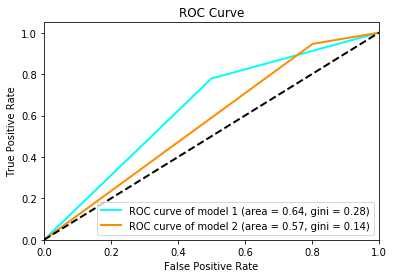

In [34]:
preds = [randFor.predict(X_test), logReg.predict(X_test), gbm.[predict(X_test)]]
plot_the_roc_dwayne_johnson(preds,['aqua', 'darkorange','deep_pink'])
#['aqua', 'darkorange', 'cornflowerblue','deep_pink','navy']

**Model Interpretation**
- Now that we have the models, it's time to interpret what they mean! This means answering questions like: which variables are most important to the model? Which variables are least important to the model? Does anything surprise you about the results?
- What are the effects of each of the variables in the model? What is the interpretation?

**Feature Importance**
- Let's take a look at the most important variables in our classifier models
- Tree Based: Variable Importance (gain)
- Logistic Regression: Coefficients, preserve sign of coefficient to determine effect on the model

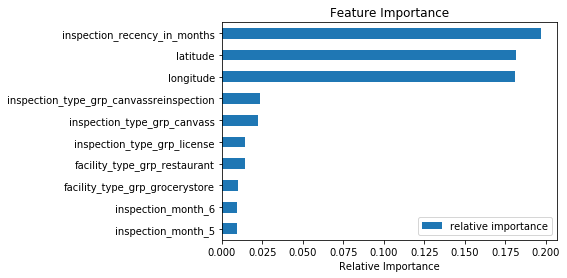

In [35]:
n = 10
plot_df = pd.DataFrame()

plot_df['relative importance'] = randFor.feature_importances_[randFor.feature_importances_.argsort()[::-1][:n]]
plot_df.index = X.columns[randFor.feature_importances_.argsort()[::-1][:n]]
plot_df.sort_values(by = 'relative importance', inplace = True)
#print(plot_df)

plot_df.plot.barh(title = 'Feature Importance')
plt.xlabel('Relative Importance')
plt.show()

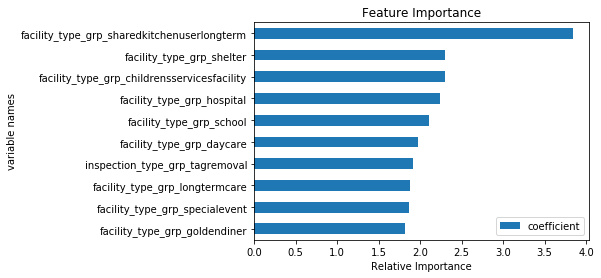

In [36]:
n = 10
plot_df = pd.DataFrame()

plot_df['variable names'] = X.columns
plot_df['coefficient'] =  logReg.coef_[0]
plot_df['abs_imp'] = [abs(c) for c in logReg.coef_[0]]
plot_df.sort_values(by = 'abs_imp', inplace = True)
plot_df = plot_df[['coefficient', 'variable names']].tail(n)
plot_df.index = plot_df['variable names']

plot_df.tail(10).plot.barh(title = 'Feature Importance')
plt.xlabel('Relative Importance')
plt.show()

Always look at the important variables for each model fit. If an unexpected variable is extremely important, be sure to try and understand why and check null values. If nulls are biased in one direction of a certain feature, it can increase importance of unexpected variables.

**Use SHAP package to help explain your model**

In many cases, such as explaining a model to client or regulator. A good way to do this is through the SHAP package. SHAP assigns each feature and importance value for a particular prediction


MW: add more info - tree explainer and partial dependence plots?

In [ ]:
from shap import TreeExplainer

In [ ]:
shapRandFor = shap.TreeExplainer(randFor, X)

**Part 3:** Hyperparameter Tuning

**Concept of Regularization**

Inherently, when fitting a model on the training dataset, it will have a better predictive accuracy on this data compared to outside data, which is why validation data exists. In order to correct overfitting and decrease bias of a model to training data, we can introduce regularization into the model. Think of this as adding a penalty or obstacle when the model tries to fit to the underlying training data. 

The figure below shows the divergence of training and test predictive error as the model complexity increases. As we introduce a small bit of complexity into the model, we can move toward a better fit on the testing set, which is what we ultimately care about most.

![altext](source\test_train_error2.png)<br>

**L1 and L2 Regularization**

- The easiest way to understand regularization is through regularized regression models. Lasso, Ridge, and Elastic Net. Recall that for regression models, coefficients are estimated using values that minimize the following (residual sum squares):
<br>![altext](source\least_squares.png)<br>
- Ridge and Lasso Regression introduce an $L_1$ and $L_2$ regularization term to the normal RSS formula.

**Ridge Regression (**$L_2$**Regularization)**
- In Ridge Regression, the $L_2$ regularization term is added to the RSS formula.
- Now, we need to minimize this equation subject to the sum of all coefficient estimates squared
- This will decrease the volatility of the parameter estimates, and force estimates close to zero when variable does not explain enough variance in the model, resulted in correlated variables sharing the signal in parameter estimates.
- The amount this effects the model is controlled by the tuning parameter (shown below as gamma) which the user selects.
<br>![altext](source\ridge.png)<br>

**Lasso Regression (**$L_1$**Regularization)**
- In Lasso Regression, the $L_1$ regularization term is added to the RSS formula.
- Now, we need to minimize this equation subject to the sum of the absolute values of all coefficient estimates
- This will decrease the volatility of the parameter estimates, and force estimates to zero when variable does not explain enough variance in the model or if variables are correlated. This is also a helpful tactic for feature selection.
- Again, amount this effects the model is controlled by the tuning parameter (shown below as gamma) which the user selects.
<br>![altext](source\lasso.png)<br>

Hyperparameters associated with XGBoost Model
- stopping, max depth, xgboost explainer

Parameter Tuning Example

Intro to grid/random/bayesian search